In [1]:
import numpy as np
import os
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord 
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
import pyccl
from scipy import stats

os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm.support.sampler import fitters

from importlib import reload  

import sys
sys.path.append('../../')
from magnification_library import *

In [2]:
clmm.__version__

'1.0.0'

In [3]:
matplotlib.rcParams.update({'font.size': 16})

In [4]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [5]:
path_file = '../../../'

In [6]:
key = 'LBGp'

## **Profiles measured with TreeCorr**

In [7]:
quant = np.load(path_file + "output_data/binned_correlation_fct_Mpc_"+key+".npy", allow_pickle=True)
quant_NK = np.load(path_file + "output_data/binned_correlation_fct_NK_Mpc_"+key+".npy", allow_pickle=True)

## **Measuring profiles with astropy and CLMM**


## Open data

In [8]:
gal_cat_raw =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, alpha_cut_err, mag_null, gal_dens, zmean = dat[np.where(dat[:,0]==key)][0][1:]

print (alpha_cut)
mag_cut

3.3193084709750664


25.499950000000002

In [9]:
selection_source = (gal_cat_raw['ra']>50) & (gal_cat_raw['ra']<73.1) & (gal_cat_raw['dec']<-27.) & (gal_cat_raw['dec']>-45.)
selection = selection_source & (gal_cat_raw['mag_i_lsst']<mag_cut) & (gal_cat_raw['redshift']>1.5)

gal_cat = gal_cat_raw[selection]

In [10]:
[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)

In [11]:
np.sum(n_halo)

21982.0

## **Magnification profiles prediction**


In [12]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

In [13]:
def magnification_biais_model(rproj, mass_lens, z_lens, alpha, z_source, cosmo_clmm, delta_so='200', massdef='mean', Mc_relation ='Diemer15'):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo_clmm.be_cosmo, Mc_relation, mdef[0], delta_so )
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.mean(clmm.theory.compute_magnification(rproj[k], mdelta=mass_lens, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo_clmm, 
                                        delta_mdef=delta_so, 
                                        massdef = massdef,
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane'))

        
    model = mu_bias(magnification, alpha) - 1. 
    
    return model, magnification
    

In [14]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm.get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

Text(0, 0.5, 'pdf')

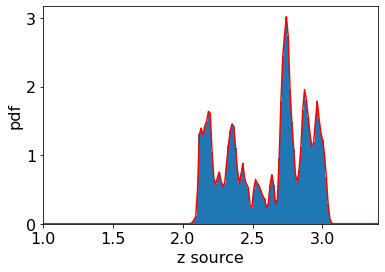

In [15]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [16]:
zint = np.linspace(0, 3.5, 1000)
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [17]:
Mc_relation = "Diemer15"
mdef = ["matter", "mean"] #differet terminology for ccl and clmm
delta_so=200


#model with the full redshift distribution
rp_Mpc = np.logspace(-2, 3, 100)

model_mbias = np.zeros((rp_Mpc.size, len(z_cl), len(mass_cl)))
model_magnification = np.zeros((rp_Mpc.size, len(z_cl), len(mass_cl)))

for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        #rp_Mpc = arcmin_to_Mpc(rp, z_cl[i,j], cosmo)
        models = magnification_biais_model(rp_Mpc, mass_cl[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)
        model_mbias[:,i,j] = models[0]
        model_magnification[:,i,j] = models[1]

../../magnification_library.py:106: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


## **Plotting figures**


## Example for one mass/z bin


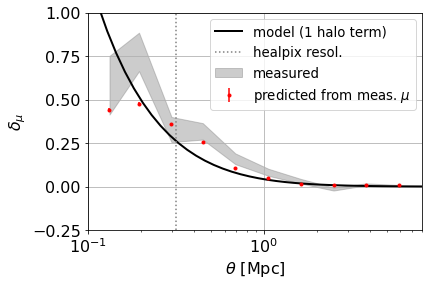

In [18]:
i,j = 1,2

corr = np.mean(gal_cat['magnification']) - 1

plt.fill_between(quant[i,j][0], y1= quant[i,j][1] - np.sqrt(np.diag(quant[i,j][2])),\
                 y2 =  quant[i,j][1]  + np.sqrt(np.diag(quant[i,j][2])),color = 'grey', alpha=0.4, label='measured')

expected_mu_bias = mu_bias(quant_NK[i,j][1] - corr, alpha_cut) - 1.
expected_mu_bias_err =  expected_mu_bias * (alpha_cut -1 ) * np.sqrt(np.diag(quant_NK[i,j][2])) /(quant_NK[i,j][1]) 

plt.errorbar(quant_NK[i,j][0], expected_mu_bias, yerr = expected_mu_bias_err,  fmt='r.', label = 'predicted from meas. $\mu$')


plt.plot(rp_Mpc, model_mbias[:,i,j],'k', lw=2,  label='model (1 halo term)')

plt.axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin).value*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')


plt.xscale('log')
plt.xlim(0.1,8)
plt.ylim(-0.25,1)
plt.grid()

plt.xlabel('$\\theta$ [Mpc]')
plt.ylabel('$\delta_{\mu}$')

plt.legend(fontsize='small', ncol=1)


## Magnification biais profiles for cluster in mass/z bins

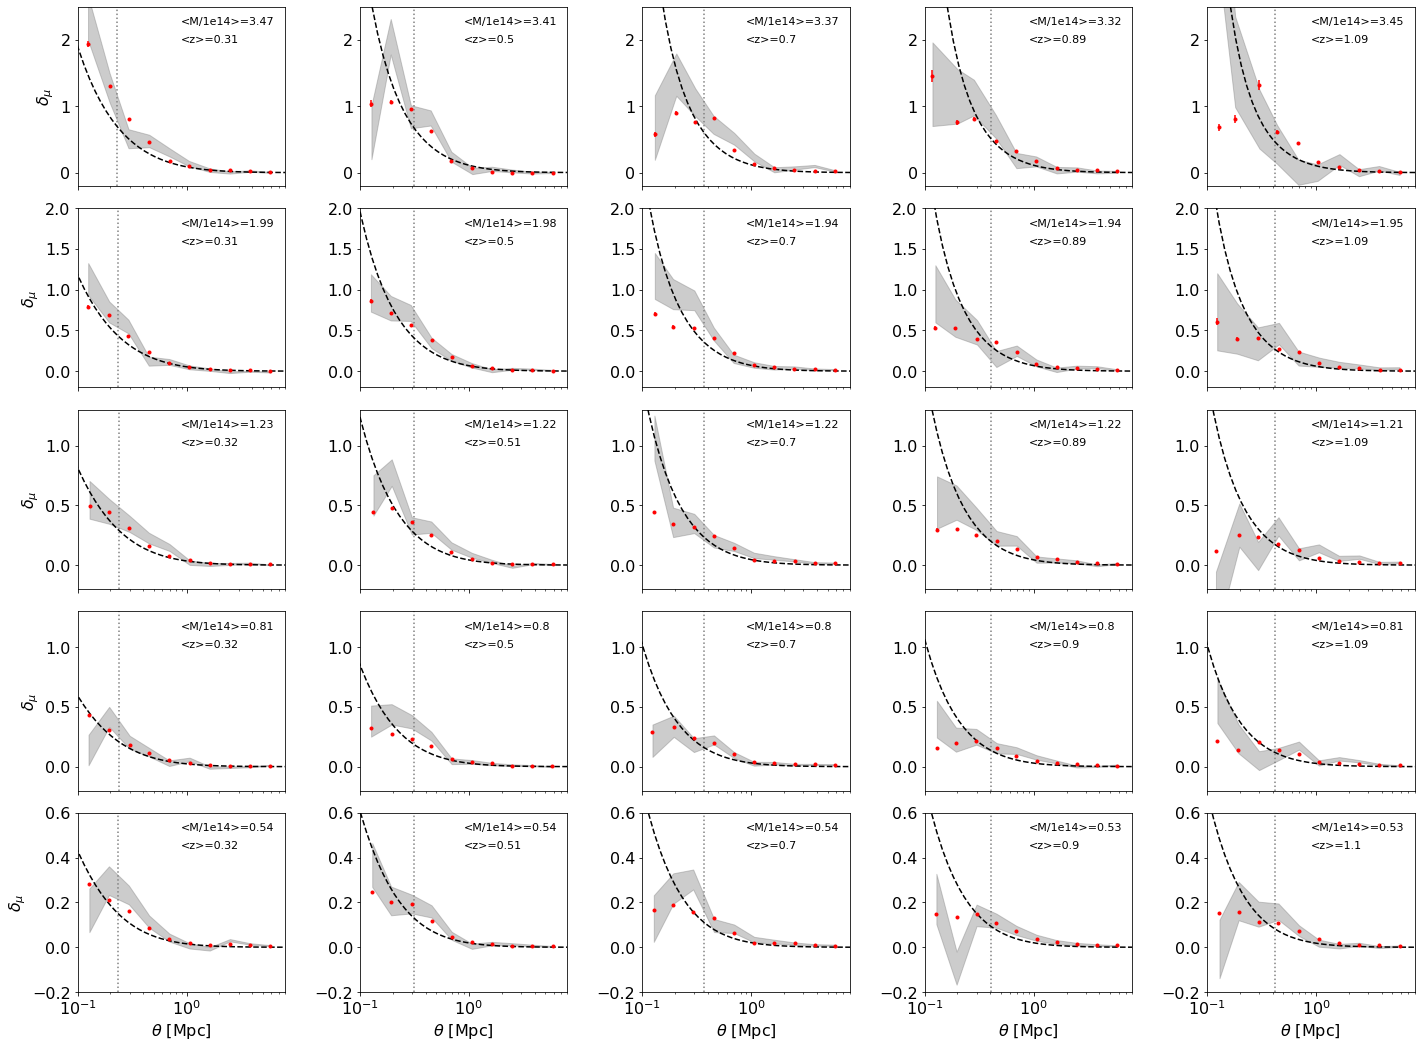

In [19]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)

corr = np.mean(gal_cat['magnification']) - 1

for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.fill_between(quant[i,j][0], y1= quant[i,j][1] -  np.sqrt(np.diag(quant[i,j][2])),\
                 y2 =  quant[i,j][1] + np.sqrt(np.diag(quant[i,j][2])),color = 'grey', alpha=0.4)

        
        expected_mu_bias = mu_bias(quant_NK[i,j][1] - corr, alpha_cut) - 1.
        expected_mu_bias_err =  expected_mu_bias * (alpha_cut -1 ) * np.sqrt(np.diag(quant_NK[i,j][2])) /(quant_NK[i,j][1]) 

        ax.errorbar(quant_NK[i,j][0], expected_mu_bias, yerr = expected_mu_bias_err,  fmt='r.', label = 'predicted from meas. $\mu$')

        ax.axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin).value*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

        ax.text(0.5, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.5, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.plot(rp_Mpc, model_mbias[:,i,j],'k--')
        ax.axvline(0, color='black')

[axes[4,j].set_xlabel('$\\theta$ [Mpc]') for j in range(5)]
[axes[i,0].set_ylabel('$\delta_{\mu}$') for i in range(5)]

plt.tight_layout()


axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,8)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-0.2,0.6)
    axes[3,i].set_ylim(-0.2,1.3)
    axes[2,i].set_ylim(-0.2,1.3)
    axes[1,i].set_ylim(-0.2,2.0)
    axes[0,i].set_ylim(-0.2,2.5)

## Fitting the mass from the magnification biais profiles using the NFW model 

In [20]:
def predict_function(radius_Mpc, logM, z_cl):
    mass_guess = 10**logM
    return magnification_biais_model(radius_Mpc, mass_guess, z_cl, alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[0]


In [21]:
def fit_mass(predict_function, data_for_fit, z):
    popt, pcov = fitters['curve_fit'](lambda radius_Mpc, logM: predict_function(radius_Mpc, logM, z),
        data_for_fit[0], 
        data_for_fit[1], 
        np.sqrt(np.diag(data_for_fit[2])), bounds=[10.,17.], absolute_sigma=True, p0=(13.))
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [22]:
fit_mass_magnification = np.zeros(z_cl.shape, dtype=object)

mass_eval = np.zeros((z_cl.shape))
mass_min = np.zeros((z_cl.shape))
mass_max = np.zeros((z_cl.shape))

for i in range(5):
    for j in range(5):
        fit_mass_magnification[i,j] = fit_mass(predict_function, quant[i,j], z_cl[i,j])
        
        mass_eval[i,j] = fit_mass_magnification[i,j]['m']
        mass_min[i,j] = fit_mass_magnification[i,j]['m'] - fit_mass_magnification[i,j]['m_err']
        mass_max[i,j] = fit_mass_magnification[i,j]['m'] + fit_mass_magnification[i,j]['m_err']

../../magnification_library.py:106: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


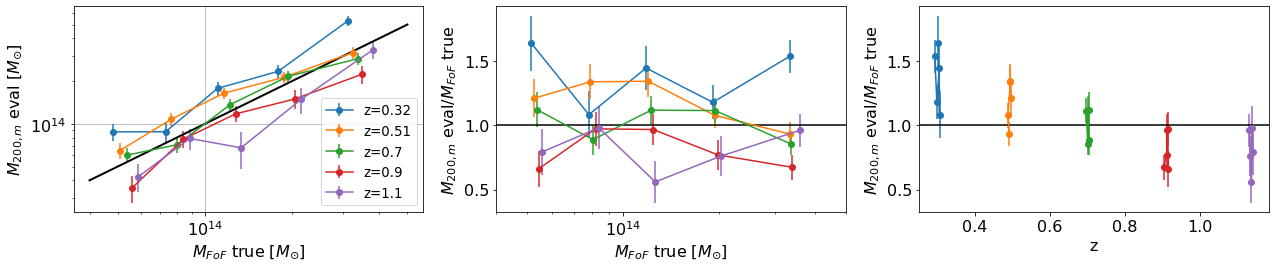

In [23]:

fig, ax = plt.subplots(1, 3, figsize=(18,4))

ax[0].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[0].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[0].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[0].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[0].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),fmt='-o', label ="z="+str(round(z_cl[4,0],2)))


ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend(fontsize = 'small', ncol=1)
ax[0].set_xlabel("$M_{FoF}$ true [$M_{\odot}$]")
ax[0].set_ylabel("$M_{200,m}$ eval [$M_{\odot}$]")
ax[0].grid()

ax[1].errorbar(mass_cl[0,:]*0.96, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[1].errorbar(mass_cl[1,:]*0.98, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[1].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[1].errorbar(mass_cl[3,:]*1.02, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[1].errorbar(mass_cl[4,:]*1.04, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[1].set_xlim(4e13, 5e14)
ax[1].set_xscale('log')
ax[1].axhline(1, color='black')
#ax[1].legend()
ax[1].set_xlabel("$M_{FoF}$ true [$M_{\odot}$]")
ax[1].set_ylabel("$M_{200,m}$ eval/$M_{FoF}$ true")

ax[2].errorbar(z_cl[0,:]*0.96, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[2].errorbar(z_cl[1,:]*0.98, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[2].errorbar(z_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[2].errorbar(z_cl[3,:]*1.02, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[2].errorbar(z_cl[4,:]*1.04, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[2].axhline(1, color='black')
ax[2].set_ylabel("$M_{200,m}$ eval/$M_{FoF}$ true")
ax[2].set_xlabel('z')


plt.tight_layout()

In [24]:
np.save(path_file + "output_data/fitted_mass_from_magnification_bias_"+key+"_"+mdef[0]+str(delta_so)+"_cM_"+Mc_relation,[mass_eval, mass_min, mass_max])

## Comparison to the mass fitted from the magnification profile

In [25]:
mass_eval_mag, mass_min_mag, mass_max_mag = np.load(path_file + "output_data/fitted_mass_from_magnification_"+key+"_"+mdef[0]+str(delta_so)+"_cM_"+Mc_relation+".npy")

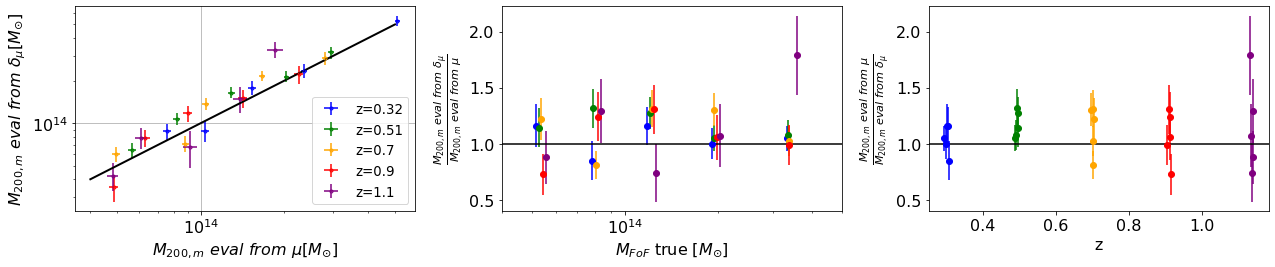

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))# sharex=True )#,sharey=True)

colors = ["blue", "green" , "orange", "red", "purple"]

ax[0].errorbar(mass_eval_mag[0,:], mass_eval[0,:],xerr = (mass_eval_mag[0,:] - mass_min_mag[0,:], mass_max_mag[0,:] - mass_eval_mag[0,:]),\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),\
               fmt='.', color = colors[0], mfc='none', label ="z="+str(round(z_cl[0,0],2)))

ax[0].errorbar(mass_eval_mag[1,:], mass_eval[1,:],xerr = (mass_eval_mag[1,:] - mass_min_mag[1,:], mass_max_mag[1,:] - mass_eval_mag[1,:]),\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),\
               fmt='.', color = colors[1], mfc='none', label ="z="+str(round(z_cl[1,0],2)))

ax[0].errorbar(mass_eval_mag[2,:], mass_eval[2,:],xerr = (mass_eval_mag[2,:] - mass_min_mag[2,:], mass_max_mag[2,:] - mass_eval_mag[2,:]),\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),\
               fmt='.', color = colors[2], mfc='none', label ="z="+str(round(z_cl[2,0],2)))

ax[0].errorbar(mass_eval_mag[3,:], mass_eval[3,:],xerr = (mass_eval_mag[3,:] - mass_min_mag[3,:], mass_max_mag[3,:] - mass_eval_mag[3,:]),\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),\
               fmt='.', color = colors[3], mfc='none', label ="z="+str(round(z_cl[3,0],2)))

ax[0].errorbar(mass_eval_mag[4,:], mass_eval[4,:],xerr = (mass_eval_mag[4,:] - mass_min_mag[4,:], mass_max_mag[4,:] - mass_eval_mag[4,:]),\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),\
               fmt='.', color = colors[4], mfc='none', label ="z="+str(round(z_cl[4,0],2)))



ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend(fontsize='small')
ax[0].set_xlabel("$M_{200,m}~eval~from~\mu$[$M_{\odot}$]")
ax[0].set_ylabel("$M_{200,m}~eval~from~\delta_{\mu}$[$M_{\odot}$]")
ax[0].grid()

ratio = mass_eval/mass_eval_mag
ratio_err = ratio *( (0.5*(mass_max - mass_min))/mass_eval +  (0.5*(mass_max_mag - mass_min_mag))/mass_eval_mag )

ax[1].errorbar(mass_cl[0,:]*0.96, ratio[0], yerr = ratio_err[0],fmt = 'o', color = colors[0])
ax[1].errorbar(mass_cl[1,:]*0.98, ratio[1], yerr = ratio_err[1],fmt = 'o', color = colors[1])
ax[1].errorbar(mass_cl[2,:]*1.00, ratio[2], yerr = ratio_err[2],fmt = 'o', color = colors[2])
ax[1].errorbar(mass_cl[3,:]*1.02, ratio[3], yerr = ratio_err[3],fmt = 'o', color = colors[3])
ax[1].errorbar(mass_cl[4,:]*1.04, ratio[4], yerr = ratio_err[4],fmt = 'o', color = colors[4])

ax[1].axhline(1, color='black')

ax[1].set_xlabel("$M_{FoF}$ true [$M_{\odot}$]")
ax[1].set_ylabel("$\\frac{M_{200,m}~eval~from~\delta_{\mu}}{M_{200,m}~eval~from~\mu}$")

ax[1].set_xlim(4e13, 5e14)
ax[1].set_xscale('log')

ax[2].errorbar(z_cl[0,:]*0.96, ratio[0], yerr = ratio_err[0], fmt = 'o', color = colors[0])
ax[2].errorbar(z_cl[1,:]*0.98, ratio[1], yerr = ratio_err[1], fmt = 'o', color = colors[1])
ax[2].errorbar(z_cl[2,:]*1.00, ratio[2], yerr = ratio_err[2], fmt = 'o', color = colors[2])
ax[2].errorbar(z_cl[3,:]*1.02, ratio[3], yerr = ratio_err[3], fmt = 'o', color = colors[3])
ax[2].errorbar(z_cl[4,:]*1.04, ratio[4], yerr = ratio_err[4], fmt = 'o', color = colors[4])

ax[2].axhline(1, color='black')
ax[2].set_ylabel("$\\frac{M_{200,m}~eval~from~\mu}{M_{200,m}~eval~from~\delta_{\mu}}$")
ax[2].set_xlabel('z')

plt.tight_layout()

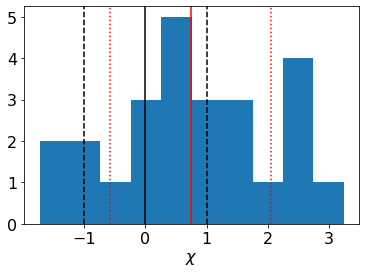

In [27]:
diff = (mass_eval - mass_eval_mag)/1e14
diff_err = (1/1e14) * np.sqrt((0.5*(mass_max - mass_min))**2 + (0.5*(mass_max_mag - mass_min_mag))**2)

plt.hist((diff/diff_err).flatten());

plt.xlabel('$\chi$')

plt.axvline(0, color='black')
plt.axvline(-1, color='black', ls='--')
plt.axvline(1, color='black', ls='--')

plt.axvline(np.mean((diff/diff_err).flatten()), color='red')
plt.axvline(np.mean((diff/diff_err).flatten()) - np.std((diff/diff_err).flatten()), color='red', ls=':')
plt.axvline(np.mean((diff/diff_err).flatten()) + np.std((diff/diff_err).flatten()), color='red', ls=':')

In [28]:
print("$\chi$ stats \n", \
      "mean",np.round(np.mean((diff/diff_err).flatten()),2),\
      ", mean err", np.round(np.std((diff/diff_err).flatten())/np.sqrt(25),2),\
      ", std", np.round(np.std((diff/diff_err).flatten()),2),\
      ", std approx err", np.round(np.std((diff/diff_err).flatten())/np.sqrt(2*(25-1)),2))

$\chi$ stats 
 mean 0.74 , mean err 0.26 , std 1.31 , std approx err 0.19


## Profile plot with the model corresponding to the fitted mass

In [29]:
model_for_fitted_mass = np.zeros(z_cl.shape,dtype=object)
model_for_fitted_mass_min = np.zeros(z_cl.shape,dtype=object)
model_for_fitted_mass_max = np.zeros(z_cl.shape,dtype=object)

for i in range(z_cl.shape[0]):
    for j in range(z_cl.shape[1]):
        model_for_fitted_mass[i,j] = magnification_biais_model(rp_Mpc, mass_eval[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[0]
        model_for_fitted_mass_min[i,j] = magnification_biais_model(rp_Mpc, mass_min[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[0]
        model_for_fitted_mass_max[i,j] = magnification_biais_model(rp_Mpc, mass_max[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)[0]

../../magnification_library.py:106: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


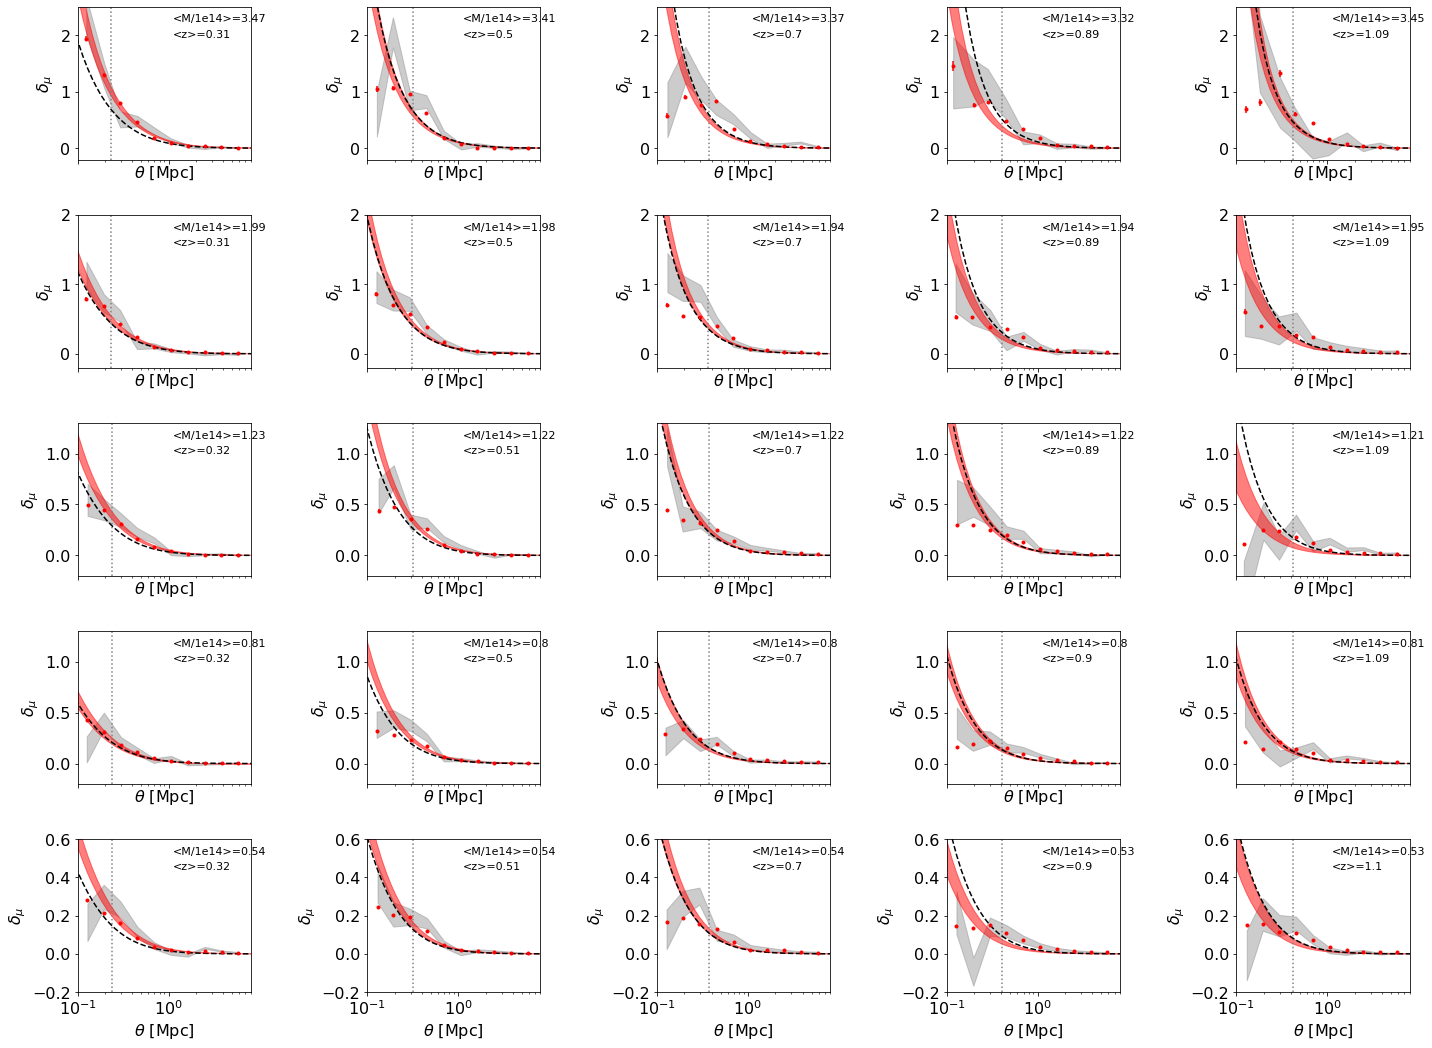

In [30]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)

corr = np.mean(gal_cat['magnification']) - 1

for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        ax = axes[5-1-k,h]
        
        ax.fill_between(quant[i,j][0], y1= quant[i,j][1] -  np.sqrt(np.diag(quant[i,j][2])),\
                 y2 =  quant[i,j][1] + np.sqrt(np.diag(quant[i,j][2])),color = 'grey', alpha=0.4)

        
        expected_mu_bias = mu_bias(quant_NK[i,j][1] - corr, alpha_cut) - 1.
        expected_mu_bias_err =  expected_mu_bias * (alpha_cut -1 ) * np.sqrt(np.diag(quant_NK[i,j][2])) /(quant_NK[i,j][1]) 

        ax.errorbar(quant_NK[i,j][0], expected_mu_bias, yerr = expected_mu_bias_err,  fmt='r.', label = 'predicted from meas. $\mu$')

        ax.axvline(cosmo.kpc_proper_per_arcmin(z_cl[i,j]).to(u.Mpc/u.arcmin).value*healpy.nside2resol(4096, arcmin = True), linestyle="dotted", color='grey', label ='healpix resol.')

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
          
        ax.set_xlabel('$\\theta$ [Mpc]')
        ax.set_ylabel('$\delta_{\mu}$')

        ax.plot(rp_Mpc, model_mbias[:,i,j],'k--')
        
        ax.fill_between(rp_Mpc, y1 = model_for_fitted_mass_min[i,j], y2 = model_for_fitted_mass_max[i,j],color='red', alpha=0.5)
        
plt.tight_layout()


axes[0,0].set_xscale('log')
axes[0,0].set_xlim(0.1,8)

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-0.2,0.6)
    axes[3,i].set_ylim(-0.2,1.3)
    axes[2,i].set_ylim(-0.2,1.3)
    axes[1,i].set_ylim(-0.2,2.0)
    axes[0,i].set_ylim(-0.2,2.5)